In [40]:
import numpy as np
import pandas as pd

import os
import math
import time
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm
import re

from gensim.models import KeyedVectors
import gensim.downloader as api

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px

# Below libraries are for text processing using NLTK
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Below libraries are for feature representation using sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Below libraries are for similarity matrices using sklearn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances

In [6]:
# Load the dataset
news_articles = pd.read_json("News_Category_Dataset_v2.json", lines = True)

In [7]:
# Inspect the dataset structure and contents
news_articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200853 entries, 0 to 200852
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   category           200853 non-null  object        
 1   headline           200853 non-null  object        
 2   authors            200853 non-null  object        
 3   link               200853 non-null  object        
 4   short_description  200853 non-null  object        
 5   date               200853 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.2+ MB


In [8]:
# Display the first few rows of the dataset
news_articles.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [9]:
# Filter articles from 2018 onwards
news_articles = news_articles[news_articles['date'] >= pd.Timestamp(2018,1,1)]

In [10]:
# Check the shape of the filtered dataset
news_articles.shape

(8583, 6)

In [22]:
# Removing all the short headline articles,less than 5 words
news_articles = news_articles[news_articles['headline'].apply(lambda x: len(x.split())>5)]
print("Total number of articles after removal of headlines with short title:", news_articles.shape[0])
# Checking and removing all the duplicates
# inplace=True: This argument specifies that the sorting operation should modify the DataFrame news_articles directly. If inplace were set to False (which is the default), the method would return a new DataFrame with the sorted values, leaving the original DataFrame unchanged.
news_articles.sort_values('headline',inplace=True, ascending=False) 
# keep='first' (default): Mark all duplicates as True except for the first occurrence.
# keep='last': Mark all duplicates as True except for the last occurrence.
# keep=False: Mark all duplicates as True. This means that all occurrences of a duplicate item are marked, not just the repeats.
duplicated_articles_series = news_articles.duplicated('headline', keep = 'first')
news_articles = news_articles[~duplicated_articles_series]
print("Total number of articles after removing duplicates:", news_articles.shape[0])

Total number of articles after removal of headlines with short title: 8485
Total number of articles after removing duplicates: 8485


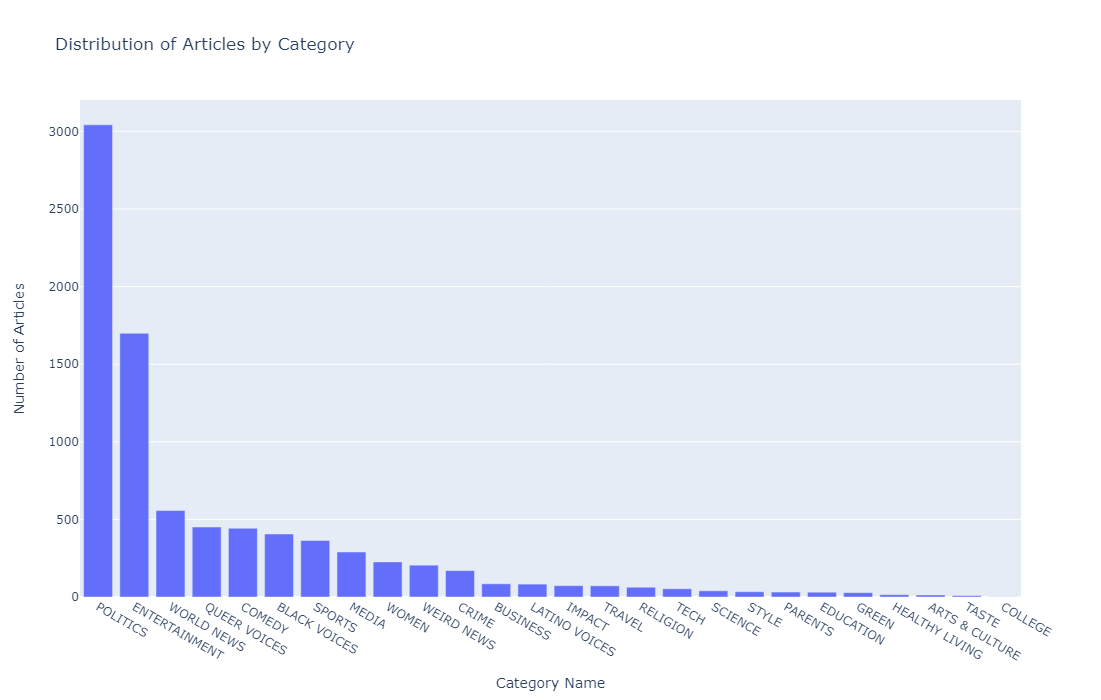

In [28]:
# Create a bar chart to visualize the distribution of articles by category using Plotly Express
# value_counts(): This method counts the occurrences of each unique value in the category column of the news_articles DataFrame. It then automatically sorts these counts in descending order
# reset_index(): This is used to convert the Series returned by value_counts() into a DataFrame, which is necessary for Plotly Express to plot the data correctly. 
fig = px.bar(news_articles['category'].value_counts().reset_index(), 
             x='index', 
             y='category', 
             labels={'index': 'Category Name', 'category': 'Number of Articles'},
             title='Distribution of Articles by Category')
fig.update_layout(width=800, height=700)
fig.show()

# # Create a bar chart to visualize the distribution of articles by category using Plotly Express
# # value_counts(): This method counts the occurrences of each unique value in the category column of the news_articles DataFrame. It then automatically sorts these counts in descending order
# # reset_index(): This is used to convert the Series returned by value_counts() into a DataFrame, which is necessary for Plotly Express to plot the data correctly. 
# fig = px.bar(news_articles['category'].value_counts().reset_index(), 
#              x='category', 
#              y='count', 
#              labels={'category': 'Category Name', 'count': 'Number of Articles'},
#              title='Distribution of Articles by Category')
# fig.update_layout(width=800, height=700)
# fig.show()

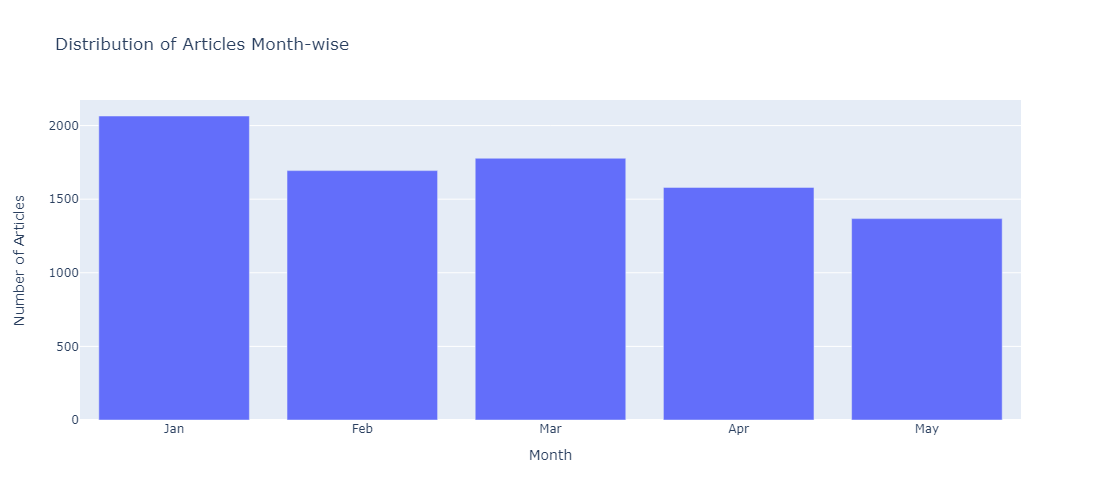

In [29]:
# Calculate the number of articles per month
news_articles_per_month = news_articles.resample('M', on='date')['headline'].count()

# Create a bar chart for the distribution of articles month-wise using Plotly Express
# .strftime("%b") is a method to format these month values into a more readable string format. %b is the format code for the abbreviated month name (e.g., 'Jan', 'Feb', 'Mar', etc.).
fig = px.bar(news_articles_per_month, x=news_articles_per_month.index.strftime("%b"), y='headline', 
             labels={'headline': 'Number of Articles', 'x': 'Month'}, 
             title='Distribution of Articles Month-wise')
fig.update_layout(width=500, height=500)
fig.show()

In [32]:
# print(news_articles['date'].min(), news_articles['date'].max())


2018-01-01 00:00:00 2018-05-26 00:00:00


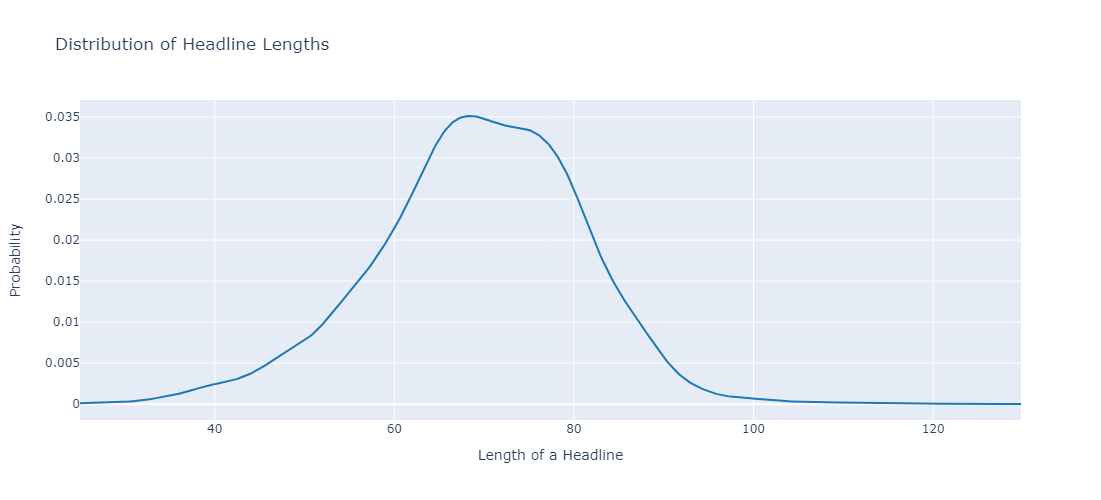

In [33]:
import plotly.figure_factory as ff

# Create a distribution plot for the length of news article headlines
fig = ff.create_distplot(
    [news_articles['headline'].str.len()], 
    ["Headline Length"], 
    show_hist=False, 
    show_rug=False
)

# Update the layout for clarity and readability
fig.update_layout(
    title='Distribution of Headline Lengths',
    xaxis_title="Length of a Headline",
    yaxis_title="Probability",
    width=500,
    height=500,
    showlegend=False
)

fig.show()


In [37]:
# Preprocessing
news_articles_temp = news_articles.copy() 
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

# Set stopwords and initialize the WordNet Lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function to preprocess and lemmatize text
def preprocess_and_lemmatize(text):
    # Remove non-alphanumeric characters
    text = re.sub(r'\W+', ' ', text)
    # Convert text to lowercase
    text = text.lower()
    # Tokenize text
    words = word_tokenize(text)
    # Remove stopwords and lemmatize
    lemmatized_words = [lemmatizer.lemmatize(word, pos="v") for word in words if word not in stop_words]
    # Join words back into a string
    return ' '.join(lemmatized_words)

# Apply the function to each headline
news_articles_temp['headline'] = [preprocess_and_lemmatize(headline) for headline in tqdm(news_articles_temp['headline'])]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\me22809\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\me22809\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
100%|████████████████████████████████████████████████████████████████████████████| 8485/8485 [00:01<00:00, 8429.84it/s]


In [38]:
# Bag of words model
# Vectorize the headlines using Bag of Words
headline_vectorizer = CountVectorizer()
headline_features = headline_vectorizer.fit_transform(news_articles_temp['headline'])

# Function to find similar articles
def bag_of_words_based_model(row_index, num_similar_items):
    couple_dist = pairwise_distances(headline_features, headline_features[row_index])
    indices = np.argsort(couple_dist.ravel())[0:num_similar_items]
    
    df = pd.DataFrame({
        'publish_date': news_articles['date'][indices].values,
        'headline': news_articles['headline'][indices].values,
        'Euclidean similarity': couple_dist[indices].ravel()
    })
    
    # Display details of the queried article
    print("="*30, "Queried Article Details", "="*30)
    print('Headline:', news_articles['headline'][indices[0]])
    
    # Display recommended similar articles
    print("\n", "="*25, "Recommended Articles:", "="*23)
    return df.iloc[1:,]  # Exclude the queried article from the recommendations

# Example usage
bag_of_words_based_model(133, 11)

============================== Queried Article Details ==============================
Headline: Woman Fired After Flipping Off Trump's Motorcade Sues Former Employer

 ========================= Recommended Articles: =======================


,publish_date,headline,Euclidean similarity
1,2018-04-02,The Trump Administration Is Suing California Again,2.828427
2,2018-03-26,Trump Ally Sues Qatar For Hacking His Email,3.162278
3,2018-04-28,Trump: Mueller Should Never Have Been Appointed,3.162278
4,2018-04-24,Spanish Woman Looks More Like Trump Than The Donald Himself,3.162278
5,2018-02-21,All They Will Call You Will Be Deportees,3.162278
6,2018-05-09,The Caliphate Of Trump And A Planet In Ruins,3.162278
7,2018-02-12,What You Should Know About Trump's Nihilist Budget,3.162278
8,2018-05-01,Texas Sues Trump Administration To End DACA,3.162278
9,2018-03-07,Stormy Daniels Suing Trump Over Nondisclosure Agreement,3.162278
10,2018-05-16,Trump Refers To Immigrants As 'Animals.' Again.,3.162278


Disadvantages

It gives very low importance to less frequently observed words in the corpus. Few words from the queried article like "employer", "flip", "fire" appear less frequently in the entire corpus so BoW method does not recommend any article whose headline contains these words. Since trump is commonly observed word in the corpus so it is recommending the articles with headline containing "trump".
BoW method doesn't preserve the order of words.

In [39]:
# TF-IDF method
# Vectorize the headlines using TF-IDF, note min_df could be 0 in the previous version but now it must be larger than 0
tfidf_headline_vectorizer = TfidfVectorizer(min_df=0)
tfidf_headline_features = tfidf_headline_vectorizer.fit_transform(news_articles_temp['headline'])

# Function to find similar articles based on TF-IDF
def tfidf_based_model(row_index, num_similar_items):
    # Calculate Euclidean distances from the given article
    couple_dist = pairwise_distances(tfidf_headline_features, tfidf_headline_features[row_index])
    # Get indices of articles with the smallest distances
    indices = np.argsort(couple_dist.ravel())[0:num_similar_items]
    
    # Create a DataFrame for the similar articles
    df = pd.DataFrame({
        'publish_date': news_articles['date'][indices].values,
        'headline': news_articles['headline'][indices].values,
        'Euclidean similarity': couple_dist[indices].ravel()
    })
    
    # Display queried article details
    print("="*30, "Queried Article Details", "="*30)
    print('Headline:', news_articles['headline'][indices[0]])
    
    # Display recommended similar articles
    print("\n", "="*25, "Recommended Articles:", "="*23)
    return df.iloc[1:,]  # Exclude the queried article from the recommendations

# Example usage
tfidf_based_model(133, 11)

============================== Queried Article Details ==============================
Headline: Woman Fired After Flipping Off Trump's Motorcade Sues Former Employer

 ========================= Recommended Articles: =======================


,publish_date,headline,Euclidean similarity
1,2018-05-21,The Supreme Court Just Made It A Lot Harder For You To Sue Your Employer,1.164067
2,2018-04-02,The Trump Administration Is Suing California Again,1.253867
3,2018-04-10,"Lou Dobbs Flips Out On Live TV, Urges Trump To 'Fire The SOB' Robert Mueller",1.258810
4,2018-04-26,Cardi B's Former Manager Sues Her For $10 Million,1.268704
5,2018-04-03,A Third Woman Is Suing To Break A Trump-Related Nondisclosure Agreement,1.274264
6,2018-02-24,Former RNC Chair Fires Back At Claim He Was Only Hired Because He Was Black,1.274847
7,2018-01-16,State Employer Side Payroll Taxes And Loser Liberalism,1.276696
8,2018-02-21,Democrats Flip Kentucky State House Seat Where Trump Won Overwhelmingly,1.282008
9,2018-01-09,Big Tax Game Hunting: Employer Side Payroll Taxes,1.285147
10,2018-02-28,Democrats Flip 2 More GOP-Held State House Seats,1.287403


Compared to BoW method, here TF-IDF method recommends the articles with headline containing words like "employer", "fire", "flip" in top 5 recommendations and these words occur less frequently in the corpus.

Disadvantages:

Bow and TF-IDF method do not capture semantic and syntactic similarity of a given word with other words but this can be captured using Word embeddings.

For example: there is a good association between words like "trump" and "white house", "office and employee", "tiger" and "leopard", "USA" and "Washington D.C" etc. Such kind of semantic similarity can be captured using word embedding techniques. Word embedding techniques like Word2Vec, GloVe and fastText leverage semantic similarity between words.

In [41]:
# Word2vec
# Load the Word2Vec model
word2vec_model = api.load('word2vec-google-news-300')

# Ensure the model is KeyedVectors for consistency
assert isinstance(word2vec_model, KeyedVectors), "Model should be an instance of KeyedVectors"
vocabulary = set(word2vec_model.index_to_key)

# Function to create averaged Word2Vec vectors for headlines
def average_word_vectors(headline, model, vocabulary, num_features):
    words = headline.split()
    feature_vector = np.mean([model[word] for word in words if word in vocabulary] or [np.zeros(num_features)], axis=0)
    return feature_vector

# Apply function to each headline
w2v_headlines = np.array([average_word_vectors(headline, word2vec_model, vocabulary, 300) for headline in news_articles_temp['headline']])

# Function to find similar articles based on average Word2Vec vectors
def avg_w2v_based_model(row_index, num_similar_items):
    distances = pairwise_distances(w2v_headlines, w2v_headlines[row_index].reshape(1, -1))
    indices = np.argsort(distances.ravel())[0:num_similar_items]

    # Create DataFrame for displaying results
    similar_articles = pd.DataFrame({
        'publish_date': news_articles['date'][indices].values,
        'headline': news_articles['headline'][indices].values,
        'Euclidean similarity': distances[indices].ravel()
    })

    # Display details of the queried article
    print("="*30, "Queried Article Details", "="*30)
    print('Headline:', news_articles['headline'][indices[0]])

    # Display recommended articles
    print("\n", "="*25, "Recommended Articles:", "="*23)
    return similar_articles.iloc[1:,]

# Example usage
avg_w2v_based_model(133, 11)

============================== Queried Article Details ==============================
Headline: Woman Fired After Flipping Off Trump's Motorcade Sues Former Employer

 ========================= Recommended Articles: =======================


,publish_date,headline,Euclidean similarity
1,2018-03-19,White House Lawyer Insists Trump Isn't Considering Firing Mueller,1.087796
2,2018-02-24,Former RNC Chair Fires Back At Claim He Was Only Hired Because He Was Black,1.097608
3,2018-01-23,Former Trump Aide's Fiancee Warns White House: ‘A Lot To Come’,1.101049
4,2018-03-07,"Former Trump Attorney Stuns 'Fox & Friends,' Says Stormy Daniels NDA Is Likely Invalid",1.110137
5,2018-01-08,'Fire And Fury' Legal Team Hits Back At Trump In New Statement,1.113800
6,2018-03-17,Trump’s Legal Team Says It Can Sue Stormy Daniels For $20 Million,1.117615
7,2018-02-20,Trump Claims He 'Never Met' Woman Accusing Him Of Sexually Assaulting Her In Trump Tower,1.120820
8,2018-03-27,Attorney Who Declined A Job On Trump's Legal Team Rips 'Turmoil' In White House,1.131882
9,2018-01-22,"Lindsey Graham Slams Trump Aide, Says White House Staff Making Negotiations ‘Difficult’",1.145354
10,2018-01-25,Trump HUD Official Lynne Patton Under Fire After Calling Journalist 'Miss Piggy',1.146078


Here, Word2Vec based representation recommends the headlines containing the word white house which is associated with the word trump in the queried article. Similarly, it recommends the headlines with words like "offical", "insist" which have semantic similarity to the words "employer", "sue" in the queried headline.